variáveis de interesse:
- released_month
- streams
- bpm
- speechiness_%
- artist_count
- in_apple_charts & in_deezer_charts & in_spotify_charts & in_deezer_charts
- artist_count

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [68]:
meses = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]

In [69]:
df = pd.read_csv("spotify-2023.csv")


In [70]:
df = pd.read_csv("spotify-2023-enriched.csv")
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

df.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,artist_gender,artist_nationality,artist_type,artist_genre
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,89,83,31,0,8,4,"female, male","US, KR","Person, Person",pop rap
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,61,74,7,0,10,4,male,PR,Person,latin
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,32,53,17,0,31,6,female,US,Person,pop
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817.0,116,...,58,72,11,0,11,15,female,US,Person,pop
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322.0,84,...,23,80,14,63,11,6,male,PR,Person,pop


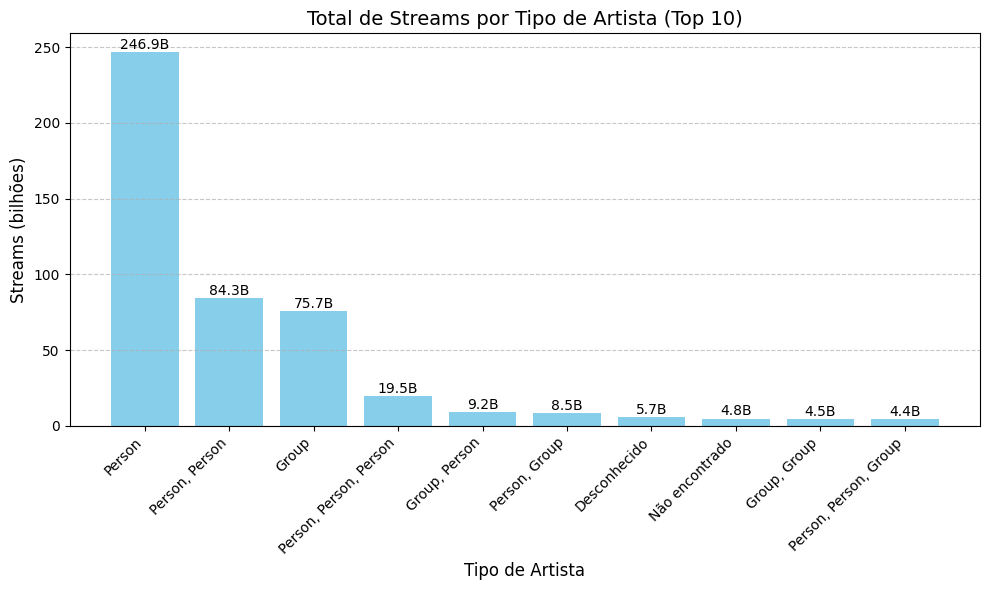

In [71]:
# Agrupando streams por tipo de artista
artist_type_streams = df.groupby('artist_type')['streams'].sum() / 1e9
artist_type_streams = artist_type_streams.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(artist_type_streams.index[:10], artist_type_streams.values[:10], color='skyblue')

# Adicionando valores sobre as barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}B', ha='center', va='bottom', fontsize=10)

plt.title('Total de Streams por Tipo de Artista (Top 10)', fontsize=14)
plt.xlabel('Tipo de Artista', fontsize=12)
plt.ylabel('Streams (bilhões)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

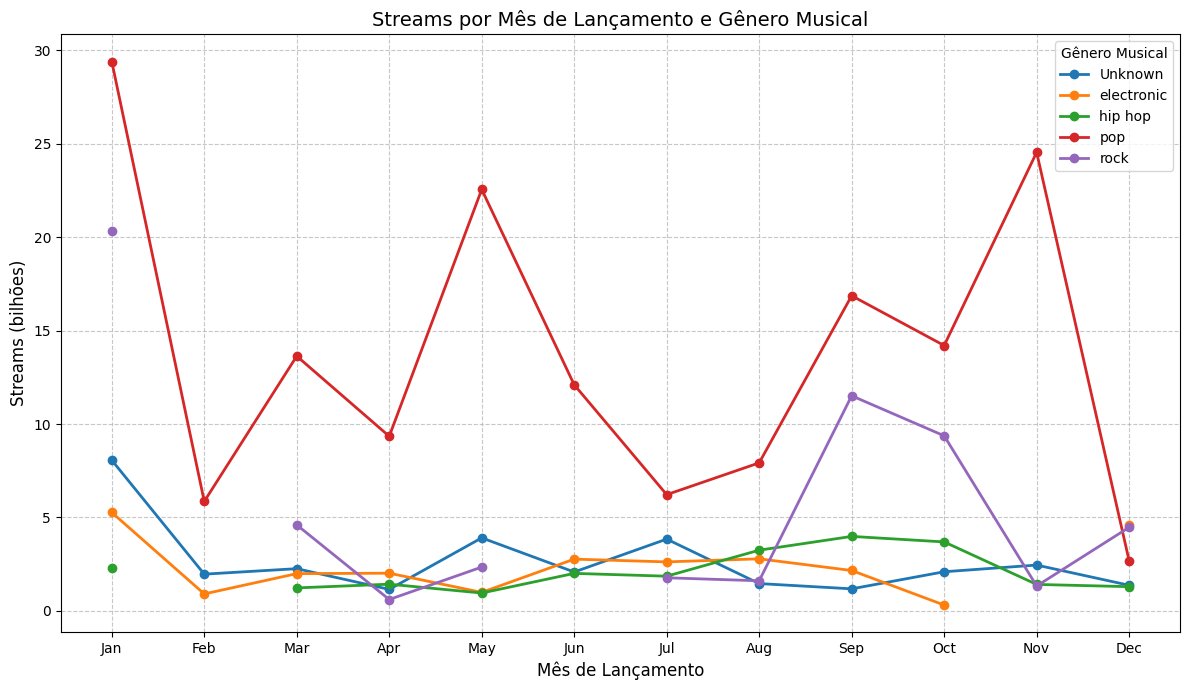

In [75]:
# Agrupando streams por mês de lançamento e gênero primário
time_genre = df.groupby(['released_month', 'artist_genre'])['streams'].sum() / 1e9
time_genre = time_genre.reset_index()

# Filtrando para os 5 gêneros mais populares para melhor visualização
top_genres = df.groupby('artist_genre')['streams'].sum().nlargest(5).index

# Pivotando para criar uma tabela com meses x gêneros
pivot_data = time_genre[time_genre['artist_genre'].isin(top_genres)].pivot(
    index='released_month', 
    columns='artist_genre', 
    values='streams'
)

# Plotando gráfico de linhas
plt.figure(figsize=(12, 7))
for genre in pivot_data.columns:
    plt.plot(range(1, 13), pivot_data[genre], marker='o', linewidth=2, label=genre)

plt.title('Streams por Mês de Lançamento e Gênero Musical', fontsize=14)
plt.xlabel('Mês de Lançamento', fontsize=12)
plt.ylabel('Streams (bilhões)', fontsize=12)
plt.xticks(range(1, 13), meses)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Gênero Musical')
plt.tight_layout()
plt.show()

In [77]:
def simplify_artist_type(artist_types):
    if pd.isna(artist_types) or not isinstance(artist_types, str):
        return "Desconhecido"
    
    try:
        types_list = [t.strip() for t in artist_types.split(',')]
        
        # Verificando presença de cada tipo
        has_person = any("Person" in t for t in types_list)
        has_group = any("Group" in t for t in types_list)
        
        if has_person and has_group:
            return "Colaboração (Pessoa+Grupp)"
        elif has_person:
            return "Pessoa"
        elif has_group:
            return "Grupo"
        else:
            return "Desconhecido"
    except Exception:
        return "Desconhecido"

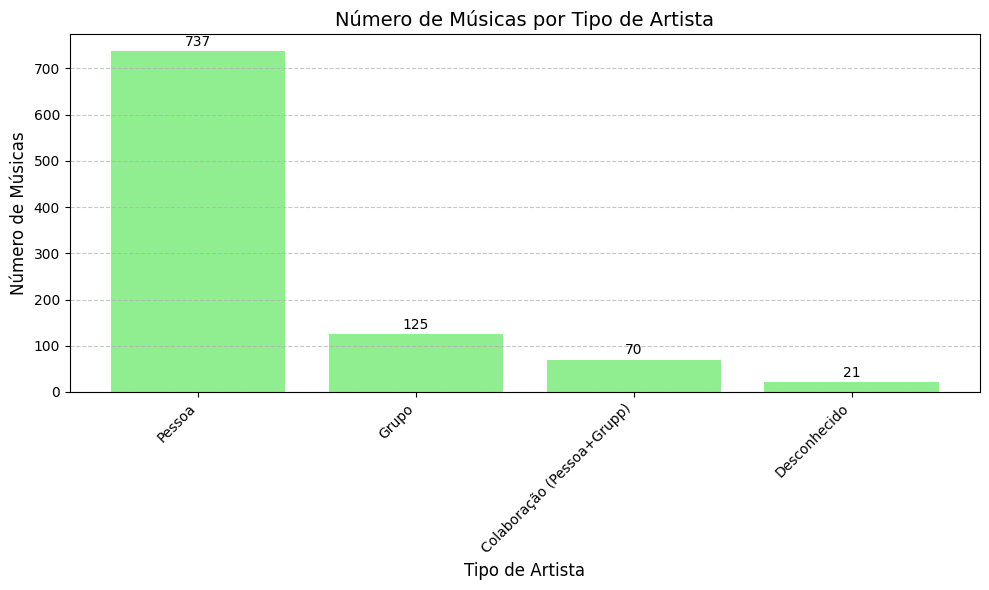

In [78]:
# Contar o número de músicas por tipo de artista simplificado
df['simplified_type'] = df['artist_type'].apply(simplify_artist_type)
appearances_per_type = df['simplified_type'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(appearances_per_type.index, appearances_per_type.values, color='lightgreen')

# Adicionando valores sobre as barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title('Número de Músicas por Tipo de Artista', fontsize=14)
plt.xlabel('Tipo de Artista', fontsize=12)
plt.ylabel('Número de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


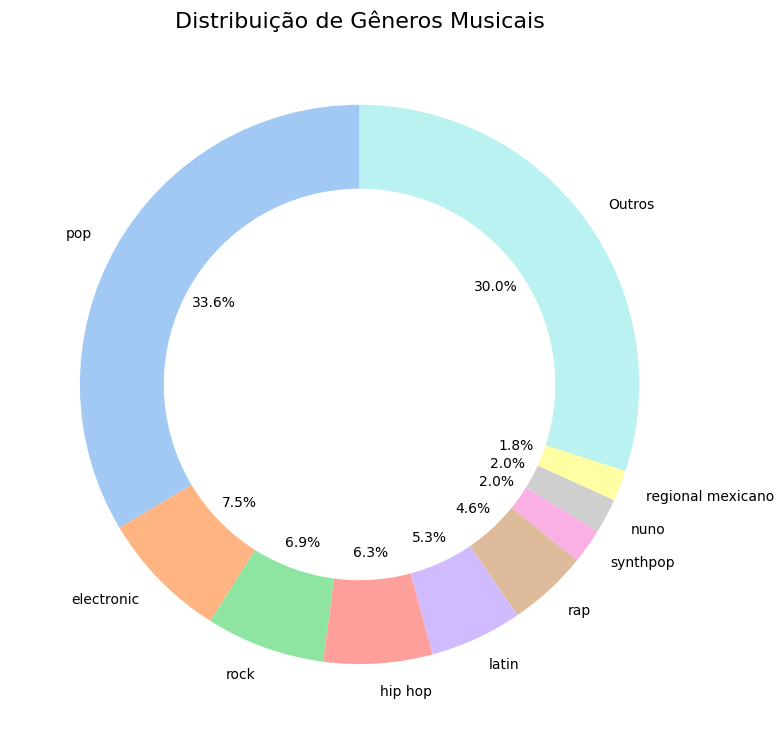

In [79]:
# Verificando a presença da coluna de gêneros
if 'artist_genres' in df.columns:
    genre_column = 'artist_genres'
elif 'artist_genre' in df.columns:
    genre_column = 'artist_genre'
else:
    print("Coluna de gêneros não encontrada. Usando a primeira coluna disponível como exemplo.")
    genre_column = df.columns[0]

# Extraindo e contando gêneros (considerando que podem estar em formato de lista separada por vírgulas)
all_genres = []
for genres in df[genre_column].dropna():
    if isinstance(genres, str):
        all_genres.extend([g.strip() for g in genres.split(',')])

# Criando Series com contagem de gêneros
genre_counts = pd.Series(all_genres).value_counts()
# Selecionando os 10 gêneros mais frequentes
top_genres = genre_counts.head(10)

# Removendo o gênero "Unknown" se presente
if 'Unknown' in top_genres.index:
    top_genres = top_genres.drop('Unknown')

# Calculando a soma dos gêneros restantes para representar como "Outros"
others_count = genre_counts[10:].sum()

# Adicionando "Outros" à lista de gêneros
top_genres['Outros'] = others_count

# Criando gráfico de rosca
plt.figure(figsize=(8, 8))
plt.pie(
    top_genres.values,
    labels=top_genres.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel"),
    wedgeprops={'width': 0.3}
)

plt.title('Distribuição de Gêneros Musicais', fontsize=16)
plt.tight_layout()
plt.show()

Estatísticas por categoria de artista:
     artist_category       streams  count  streams_per_song
0  Colaboração (2-3)  1.498842e+11    339      4.421363e+08
1   Colaboração (4+)  6.602597e+09     27      2.445406e+08
2               Solo  3.329720e+11    587      5.672437e+08




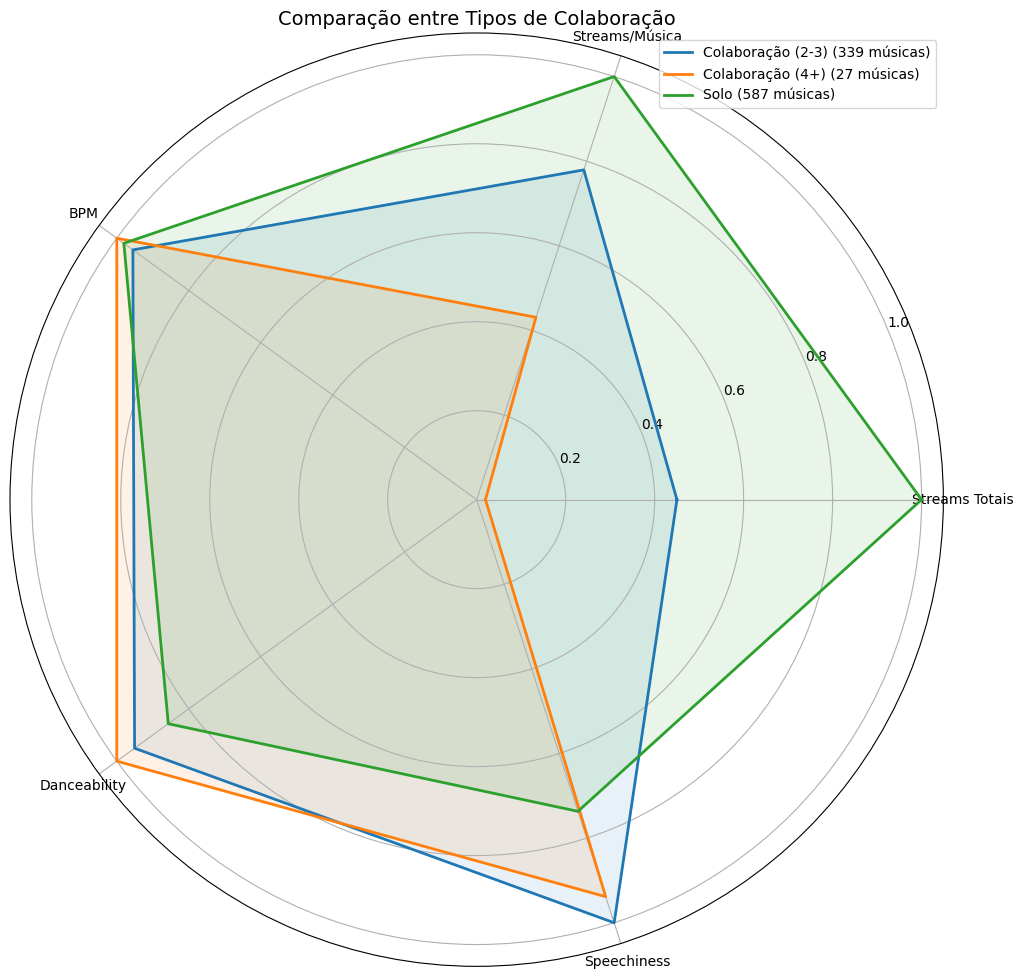

<Figure size 1200x600 with 0 Axes>

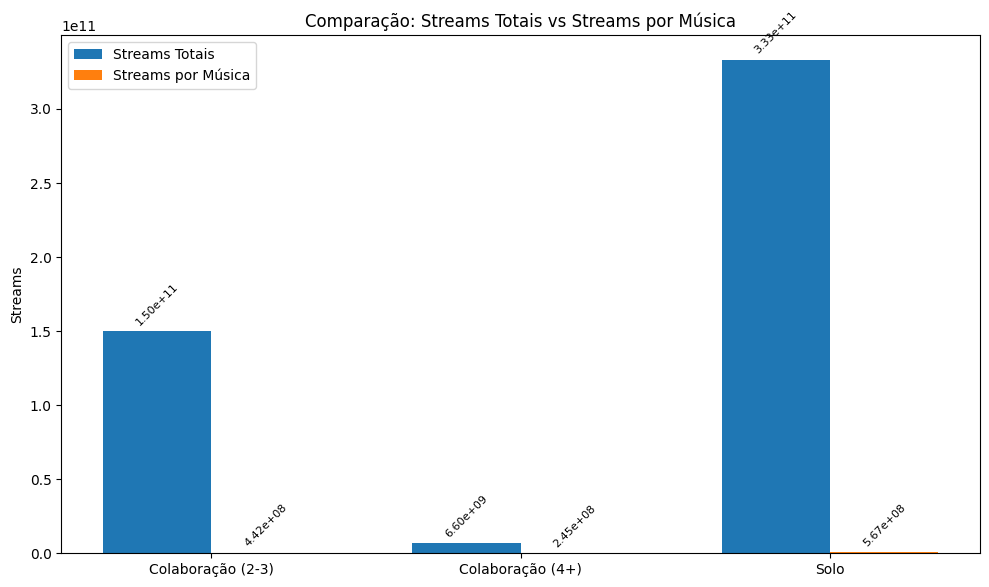

In [87]:
# Criando categorias baseadas na contagem de artistas
df['artist_category'] = df['artist_count'].apply(
    lambda x: 'Solo' if x == 1 else 'Colaboração (2-3)' if x <= 3 else 'Colaboração (4+)'
)

# Calculando métricas mais refinadas
artist_category_stats = df.groupby('artist_category').agg({
    'streams': 'sum',  # Soma total de streams para cada categoria
    'bpm': 'mean',
    'danceability_%': 'mean',
    'speechiness_%': 'mean',
    'artist_count': 'count'  # Quantidade de músicas em cada categoria
}).reset_index()

# Renomeando para clareza
artist_category_stats = artist_category_stats.rename(columns={'artist_count': 'count'})

# Adicionando coluna de streams médios por música na categoria
artist_category_stats['streams_per_song'] = artist_category_stats['streams'] / artist_category_stats['count']

# Mostrando os valores brutos e normalizados
print("Estatísticas por categoria de artista:")
print(artist_category_stats[['artist_category', 'streams', 'count', 'streams_per_song']])
print("\n")

# Normalizando os valores para o gráfico de radar
for col in ['streams', 'streams_per_song', 'bpm', 'danceability_%', 'speechiness_%']:
    max_val = artist_category_stats[col].max()
    artist_category_stats[f'{col}_norm'] = artist_category_stats[col] / max_val

# Criando um gráfico de radar
metrics = ['streams_norm', 'streams_per_song_norm', 'bpm_norm', 'danceability_%_norm', 'speechiness_%_norm']
categories = artist_category_stats['artist_category'].tolist()

# Configurando o gráfico
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Fechando o círculo
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

for i, category in enumerate(categories):
    values = artist_category_stats.loc[i, metrics].tolist()
    values += values[:1]  # Fechando o círculo
    ax.plot(angles, values, linewidth=2, label=f"{category} ({artist_category_stats.loc[i, 'count']} músicas)")
    ax.fill(angles, values, alpha=0.1)

# Adicionando rótulos
ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Streams Totais', 'Streams/Música', 'BPM', 'Danceability', 'Speechiness'])
ax.set_title('Comparação entre Tipos de Colaboração', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Gráfico adicional para visualizar streams totais vs streams por música
plt.figure(figsize=(12, 6))
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, artist_category_stats['streams'], width, label='Streams Totais')
bars2 = ax.bar(x + width/2, artist_category_stats['streams_per_song'], width, label='Streams por Música')

ax.set_ylabel('Streams')
ax.set_title('Comparação: Streams Totais vs Streams por Música')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Formatando os valores nos eixos para legibilidade
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Adicionando rótulos de valor em cada barra
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2e}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=45, fontsize=8)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

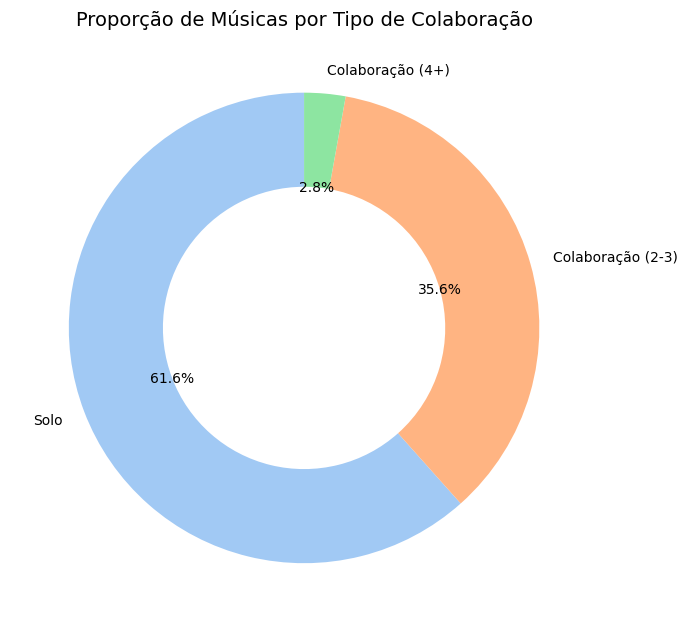

In [ ]:
plt.figure(figsize=(7, 7))
df['artist_category'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette('pastel'),
    wedgeprops={'width': 0.4}
)
plt.title('Proporção de Músicas por Tipo de Colaboração', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
taylor_swift = df[df['artist(s)_name'] == 'Taylor Swift'].copy()
taylor_swift['streams'] = taylor_swift['streams'].astype(float)
total_streams = taylor_swift['streams'].sum()
print(f"{total_streams/1e9} bilhões")

14.0536583 bilhões


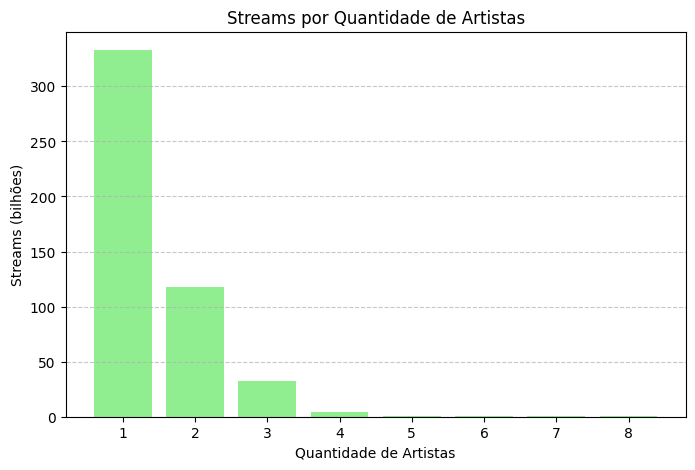

In [ ]:
# Certifique-se de que a coluna 'streams' está no formato numérico
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')

# Calculando streams médios por número de artistas
streams_by_artists = df.groupby('artist_count')['streams'].sum() / 1e9 

plt.figure(figsize=(8, 5))
plt.bar(streams_by_artists.index, streams_by_artists.values, color='lightgreen')
plt.title('Streams por Quantidade de Artistas')
plt.xlabel('Quantidade de Artistas')
plt.ylabel('Streams (bilhões)')
plt.xticks(streams_by_artists.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
columns_of_interest = [
    "artist_count",  # Number of artists contributing to the song
    "released_month",  # Month when the song was released
    "streams",  # Total number of streams on Spotify
    "bpm",  # Beats per minute, a measure of song tempo
    "in_spotify_charts",  # Presence and rank of the song on Spotify charts
    "in_apple_charts",  # Presence and rank of the song on Apple Music charts
    "in_deezer_charts",  # Presence and rank of the song on Deezer charts
    "in_shazam_charts",  # Presence and rank of the song on Shazam charts
    "danceability_%",  # Percentage indicating how suitable the song is for dancing
    "speechiness_%",  # Amount of spoken words in the song
    "artist(s)_name"
]

df = df[columns_of_interest]

In [ ]:
df.head()

,artist_count,released_month,streams,bpm,in_spotify_charts,in_apple_charts,in_deezer_charts,in_shazam_charts,danceability_%,speechiness_%,artist(s)_name
0,2,7,141381703.0,125,147,263,10,826,80,4,"Latto, Jung Kook"
1,1,3,133716286.0,92,48,126,14,382,71,4,Myke Towers
2,1,6,140003974.0,138,113,207,14,949,51,6,Olivia Rodrigo
3,1,8,800840817.0,170,100,207,12,548,55,15,Taylor Swift
4,1,5,303236322.0,144,50,133,15,425,65,6,Bad Bunny


### streams por mês de lançamento:
será que existe relação entre o mês de lançamento e as músicas fazerem mais sucesso?
faz sentido, pois músicas lançadas no início do ano acumulam os streams, enquanto as lançadas no final do ano não acumulam tanto.

de forma interessante, o gráfico não tem valores maiores no início do ano do que para o final para todos os meses, como podemos observar com feveireiro, que possui muito menos streams que dezembro, por exemplo, mesmo tendo 10 meses a mais para acumular streams.

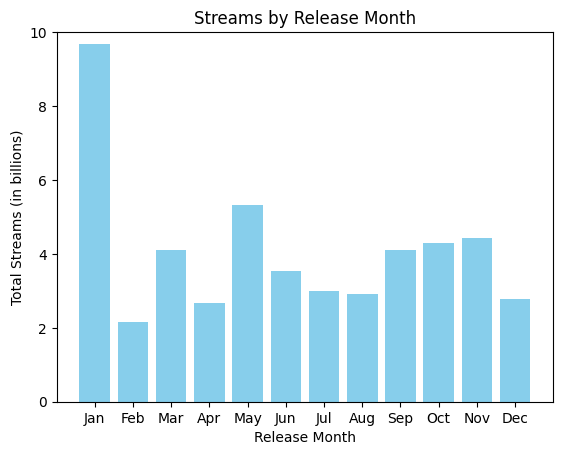

In [ ]:
plt.bar(meses, streams_by_month['Total Streams'] / 1e10, color='skyblue')

plt.title('Streams by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Total Streams (in billions)')

plt.ylim(0, 10)
plt.show()

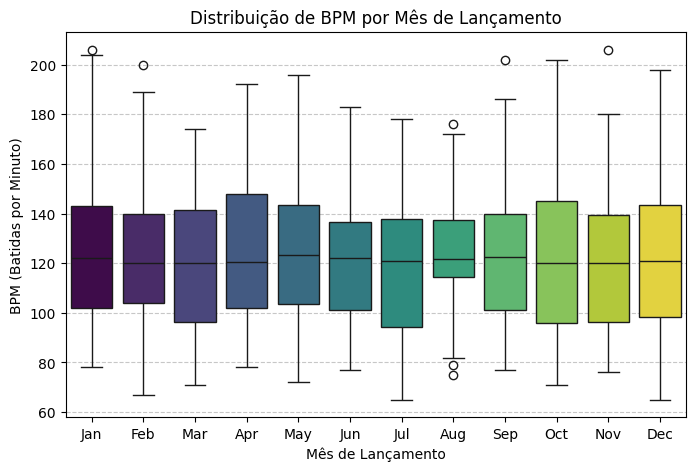

In [ ]:
# Análise de distribuição de BPM por mês
plt.figure(figsize=(8, 5))
sns.boxplot(y='bpm', x='released_month', data=df, hue='released_month', palette='viridis', dodge=False, legend=False)
plt.title('Distribuição de BPM por Mês de Lançamento')
plt.xlabel('Mês de Lançamento')
plt.ylabel('BPM (Batidas por Minuto)')
plt.xticks(ticks=range(12), labels=meses)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

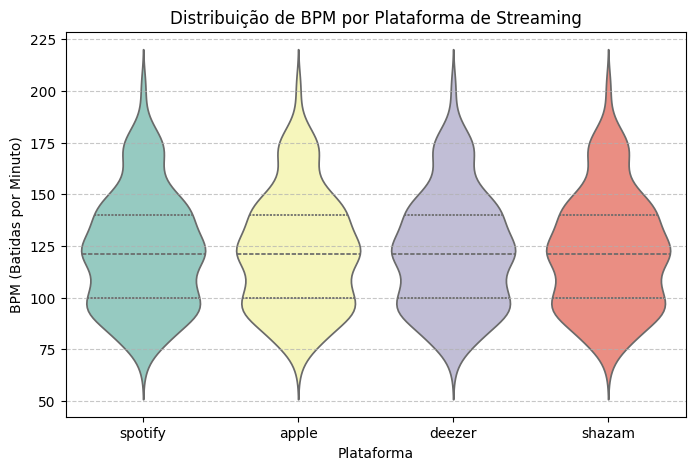

In [ ]:
# Preparando os dados para análise
presence_data = df.melt(
    id_vars=['streams', 'bpm'],  # Include 'bpm' in the id_vars
    value_vars=['in_spotify_charts', 'in_apple_charts', 'in_deezer_charts', 'in_shazam_charts'],
    var_name='Platform',
    value_name='Chart Position'
)

# Limpando nomes das plataformas
presence_data['Platform'] = presence_data['Platform'].str.replace('in_', '').str.replace('_charts', '')

# Criando o gráfico de violino
plt.figure(figsize=(8, 5))
sns.violinplot(
    x='Platform',
    y='bpm',
    data=presence_data,
    hue='Platform',
    palette='Set3',
    inner='quartile',  # Mostra quartis dentro do violino
    legend=False
)
plt.title('Distribuição de BPM por Plataforma de Streaming')
plt.xlabel('Plataforma')
plt.ylabel('BPM (Batidas por Minuto)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

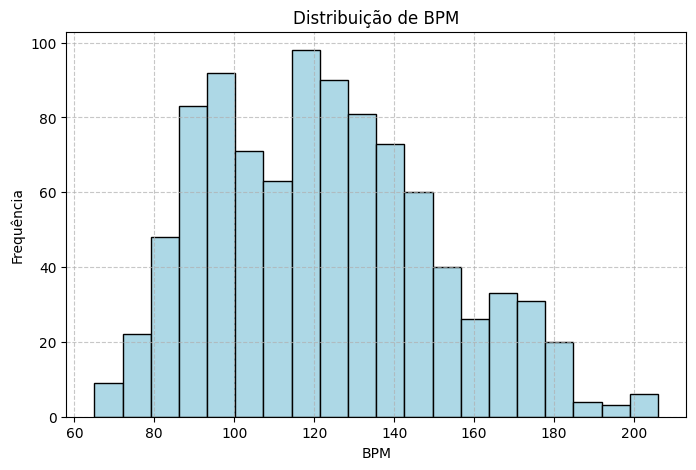

In [ ]:
# Histograma simples de BPM
plt.figure(figsize=(8, 5))
plt.hist(df['bpm'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribuição de BPM')
plt.xlabel('BPM')
plt.ylabel('Frequência')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

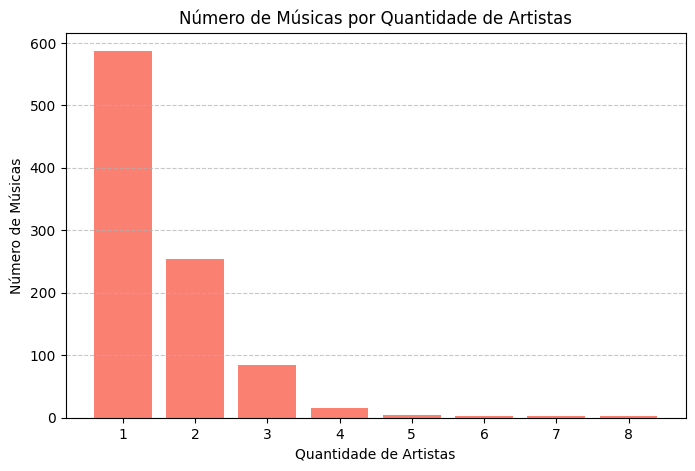

In [ ]:
# Contagem de músicas por número de artistas
artist_counts = df['artist_count'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(artist_counts.index, artist_counts.values, color='salmon')
plt.title('Número de Músicas por Quantidade de Artistas')
plt.xlabel('Quantidade de Artistas')
plt.ylabel('Número de Músicas')
plt.xticks(range(1, artist_counts.index.max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

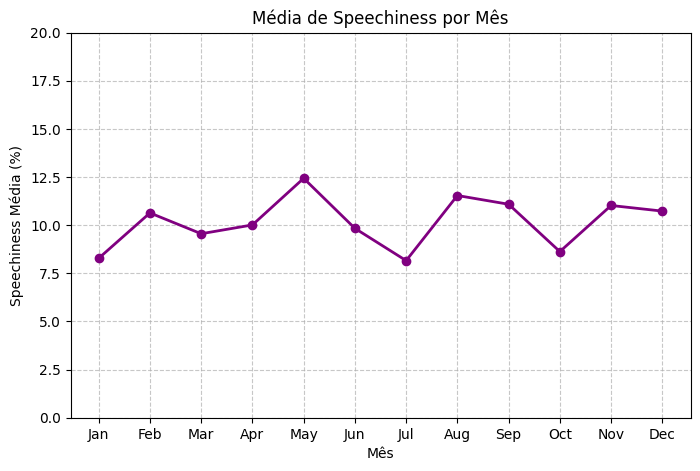

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 13), speechiness_by_month, marker='o', color='purple', linewidth=2)
plt.title('Média de Speechiness por Mês')
plt.xlabel('Mês')
plt.ylabel('Speechiness Média (%)')
plt.xticks(range(1, 13), meses)
plt.ylim(0, 20)  # Define o valor máximo do eixo Y como 20
plt.grid(linestyle='--', alpha=0.7)
plt.show()


artist(s)_name
Bad Bunny         40
Taylor Swift      38
The Weeknd        37
SZA               23
Kendrick Lamar    23
Feid              21
Drake             19
Harry Styles      17
Peso Pluma        16
Metro Boomin      14
21 Savage         14
Ed Sheeran        14
Morgan Wallen     13
BTS               13
Quevedo           12
Rauw Alejandro    12
Name: count, dtype: int64


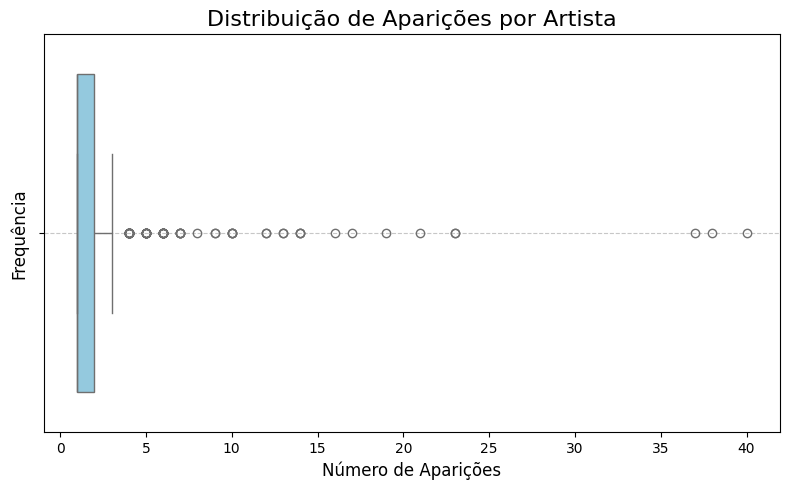

In [ ]:
# Dividindo os nomes dos artistas e contando as aparições
artist_appearances = df['artist(s)_name'].str.split(', ').explode().value_counts()

most_frequent_artists = artist_appearances[artist_appearances > 10]
print(most_frequent_artists)

plt.figure(figsize=(8, 5))
sns.boxplot(x=artist_appearances.values, color='skyblue')
plt.title('Distribuição de Aparições por Artista', fontsize=16)
plt.xlabel('Número de Aparições', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Upgrade nbformat to the required version
import plotly.graph_objects as go

In [ ]:
f = go.Figure(data=[
    go.Bar(x=most_frequent_artists.index, y=most_frequent_artists.values, marker_color='lightblue')
])

f.update_layout(
    title='Artistas Mais Frequentes',
    xaxis_title='Artistas',
    yaxis_title='Número de Aparições',
    xaxis_tickangle=-45,
    showlegend=False
)

f

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'lightblue'},
              'type': 'bar',
              'x': array(['Bad Bunny', 'Taylor Swift', 'The Weeknd', 'SZA', 'Kendrick Lamar',
                          'Feid', 'Drake', 'Harry Styles', 'Peso Pluma', 'Metro Boomin',
                          '21 Savage', 'Ed Sheeran', 'Morgan Wallen', 'BTS', 'Quevedo',
                          'Rauw Alejandro'], dtype=object),
              'y': {'bdata': 'KCYlFxcVExEQDg4ODQ0MDA==', 'dtype': 'i1'}}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Artistas Mais Frequentes'},
               'xaxis': {'tickangle': -45, 'title': {'text': 'Artistas'}},
               'yaxis': {'title': {'text': 'Número de Aparições'}}}
})